In [2]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import statistics
from datetime import datetime
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import re
import string

import torch
from torch import nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter


from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [3]:
review_train = []
with open("../dataset/review_train.json", "r") as file:
    for line in file:
        review_train.append(json.loads(line))

review_test = []
with open("../dataset/review_test.json", "r") as file:
    for line in file:
        review_test.append(json.loads(line))

In [4]:
review_train[0]
# len(review_train)

{'votes': {'funny': 0, 'useful': 1, 'cool': 0},
 'user_id': 'qVlXke5-Qm9Xr0SBcBTTnA',
 'review_id': 'K80HPQBnSg7alK7R7tIs3A',
 'stars': 1,
 'date': '2012-07-02',
 'text': 'Terrible place to shop!!! The manager is an expletive i cannot say on here. I went and bought several nails and screws as well as a rug and other items. While i was checking out the cashier charged me incorrectly for some of the screws, actually charged me more than what they were so i told the cashier and she corrected her mistake. While shopping i was there for about an hour because i was looking at paint, i even talked to a guy while i was there about different paint options as well as another lady about drill bits and about my cat condo project. anyway after i left i realize after i got home the cashier had also forgotten to give me a receipt. the rug i purchased did not work where i wanted it so i attempted to return it about 1 week after i purchased it, i went back the following weekend and the manager refused.

In [35]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00 0:00:01


In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Access the lexicon dictionary
vader_lexicon = analyzer.lexicon

# Extract negative words (words with negative sentiment scores)
negative_words = [word for word, score in vader_lexicon.items() if score < 0]
negative_words_set = set(negative_words)
print(f"Number of negative words: {len(negative_words_set)}")


Number of negative words: 4169


In [40]:
def process_sequence(datum):
    sp = set(string.punctuation)
    r = ''.join([c for c in datum['text'].lower() if c not in sp])
    return r.split()

In [51]:

def contains_negative_words(tokens, negative_words_set):
    return any(word in negative_words_set for word in tokens)

# Exploratory data
# Get some bad words and see their avg rating
bad = []  # Store ratings of entries containing negative words
seqs = []  # Store processed sequences

for d in review_train:
    # Process the text into a list of tokens
    seqs.append(process_sequence(d))

# Check for negative words in each entry
for i, (entry, review_data) in enumerate(zip(seqs, review_train)):
    has_negative_words = contains_negative_words(entry, negative_words_set)
    if has_negative_words:
        # Append the rating for reviews containing negative words
        bad.append(review_data['stars'])  # Assuming `review_data['stars']` contains the rating

if bad:
    avg_rating = sum(bad) / len(bad)
    print(f"Avg ratings containing negative words: {avg_rating}")
else:
    print("No reviews with negative words found.")


Avg ratings containing negative words: 3.578265227810234


In [45]:
!pip install nltk


In [46]:
import nltk
nltk.download('opinion_lexicon')



[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/lelezhao/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [50]:
from nltk.corpus import opinion_lexicon
import string

# Load positive words from NLTK opinion lexicon
positive_words_set = set(opinion_lexicon.positive())

# Function to check if any token is a positive word
def contains_positive_words(tokens, positive_words_set):
    """
    Checks if any token in the list of tokens is in the positive words set.
    Args:
        tokens (list): A list of words (tokens).
        positive_words_set (set): A set of positive words.
    Returns:
        bool: True if any token is found in the positive words set, False otherwise.
    """
    return any(word in positive_words_set for word in tokens)

# Exploratory data: Get average ratings for reviews with positive words
good_ratings = []  # Store ratings for reviews with positive words
seqs = []  # Store processed sequences

# Assuming `review_train` is your dataset
for d in review_train:
    # Process the text into a list of tokens
    seqs.append(process_sequence(d))

# Check for positive words in each entry
for i, (entry, review_data) in enumerate(zip(seqs, review_train)):
    has_positive_words = contains_positive_words(entry, positive_words_set)
    if has_positive_words:
        # Append the rating for reviews containing positive words
        good_ratings.append(review_data['stars'])  # Assuming `review_data['stars']` contains the rating

# Calculate and print average rating for reviews with positive words
if good_ratings:
    avg_rating = sum(good_ratings) / len(good_ratings)
    print(f"Avg ratings containing positive words: {avg_rating}")
else:
    print("No reviews with positive words found.")


Avg ratings containing positive words: 3.7981473105851213


In [49]:
# calculate avg of stars in the training set
ratings = [d['stars'] for d in review_train]
print("avg of the whole training set: ", sum(ratings)/len(ratings))

avg of the whole training set:  3.7660405056408863


In [5]:
#spliting data 
train_data = []
N = 110355
for d in review_train[:N]:
    train_data.append(d)
print(len(train_data))
valid_data = []
for d in review_train[N:]:
    valid_data.append(d)
print(len(valid_data))

110355
73570


In [6]:
def process_sequence(datum):
    seq = []
    sp = set(string.punctuation)
    # wordCount=defaultdict(int)
    r = ''.join([c for c in datum['text'].lower() if not c in sp])
    seq = r.split()
    return seq 
    # print(r)
    # for w in r.split():
    #     wordCountTrain[w] += 1

In [7]:
sequences_train = []
for d in review_train:
    sequences_train.append(process_sequence(d))
    # print(process_sequence(d))
ratings_train =[]
for d in review_train:
    ratings_train.append(d['stars'])
    # print(d['stars'])
len(sequences_train)



183925

In [61]:
import numpy as np
from collections import defaultdict, Counter
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import string
from scipy.sparse import lil_matrix


class NGramRatingModel:
    def __init__(self, n, alpha=1.0):
        self.n = n
        self.alpha = alpha
        self.ngrams = defaultdict(list)
        self.context_counts = Counter()
        self.regressor = Ridge(alpha=self.alpha)
        self.ngram_to_idx = None

    def train(self, sequences, ratings):
        for seq, rating in zip(sequences, ratings):
            seq = ['<s>'] * (self.n - 1) + seq + ['</s>']
            for i in range(len(seq) - self.n + 1):
                ngram = tuple(seq[i:i + self.n])
                self.ngrams[ngram].append(rating)
                self.context_counts[ngram[:-1]] += 1
        # self.ngrams = {ngram: ratings for ngram, ratings in self.ngrams.items() if len(ratings) > 1}
        self.ngram_to_idx = {ngram: idx for idx, ngram in enumerate(self.ngrams.keys())}
        features, targets = self._extract_features_and_targets(sequences, ratings)
        self.regressor.fit(features, targets)

    def _extract_features_and_targets(self, sequences, ratings):
        feature_matrix = lil_matrix((len(sequences), len(self.ngrams)), dtype=np.float32)
        for i, seq in enumerate(sequences):
            feature_vector = self._extract_features(seq)
            feature_matrix[i, :] = feature_vector
        return feature_matrix.tocsr(), np.array(ratings, dtype=np.float32)

    def _extract_features(self, sequence):
        sequence = ['<s>'] * (self.n - 1) + sequence + ['</s>']
        feature_vector = np.zeros(len(self.ngrams), dtype=np.float32)
        for i in range(len(sequence) - self.n + 1):
            ngram = tuple(sequence[i:i + self.n])
            if ngram in self.ngram_to_idx:
                idx = self.ngram_to_idx[ngram]
                feature_vector[idx] += 1
        return feature_vector

    def evaluate(self, sequences, ratings):
        features, targets = self._extract_features_and_targets(sequences, ratings)
        # predictions = self.regressor.predict(features)
        predictions = np.round(np.clip(self.regressor.predict(features), 1, 5))

        print(predictions)
        mse = mean_squared_error(targets, predictions)
        return mse


def process_sequence(datum):
    sp = set(string.punctuation)
    r = ''.join([c for c in datum['text'].lower() if c not in sp])
    return r.split()





In [9]:
# N = len(review_train)
# # Preprocessing
# train_sequences = [process_sequence(d) for d in review_train[:10000]]
# train_ratings = [d['stars'] for d in review_train[:10000]]

# val_sequences = [process_sequence(d) for d in review_train[40000:41999]]
# val_ratings = [d['stars'] for d in review_train[40000:41999]]




In [24]:
import random

sample_size = 20000  # Adjust based on your computational capacity
random.seed(42)  # For reproducibility
sampled_data = random.sample(review_train, sample_size)

sequences = [process_sequence(d) for d in sampled_data]
ratings = [d['stars'] for d in sampled_data]

# Split into training and validation sets
train_sequences, val_sequences, train_ratings, val_ratings = train_test_split(
    sequences, ratings, test_size=0.2, random_state=42)

In [27]:
len(train_sequences)
len(val_sequences)

4000

In [64]:
# unigram DON'T WORK TOO WELL

# Train and Evaluate
unigram_model = NGramRatingModel(n=1, alpha=1.0)
unigram_model.train(train_sequences, train_ratings)

# Validation and Test
val_mse = unigram_model.evaluate(val_sequences, val_ratings)

print(f"Validation MSE: {val_mse:.4f}")

[5. 4. 3. ... 4. 5. 2.]
Validation MSE: 1.2415


In [65]:
test_sequence = [process_sequence(d) for d in review_test]
test_rating = [d['stars'] for d in review_test]

test_mse = unigram_model.evaluate(test_sequence,test_rating)
print(f"Test MSE: {test_mse:.4f}")

[4. 5. 3. ... 5. 5. 2.]
Test MSE: 1.2913


In [62]:
#bigram
# Train and Evaluate
ngram_model = NGramRatingModel(n=2, alpha=0.5)
ngram_model.train(train_sequences, train_ratings)

# # Train Ridge Regressor
# features, targets = ngram_model._extract_features_and_targets(train_sequences, train_ratings)
# ngram_model.regressor.fit(features, targets)

# Validation and Test
val_mse = ngram_model.evaluate(val_sequences, val_ratings)

print(f"Validation MSE: {val_mse:.4f}")

[5. 3. 3. ... 4. 4. 2.]
Validation MSE: 0.9775


In [63]:

test_sequence = [process_sequence(d) for d in review_test]
test_rating = [d['stars'] for d in review_test]

test_mse = ngram_model.evaluate(test_sequence,test_rating)
print(f"Test MSE: {test_mse:.4f}")


[4. 4. 3. ... 5. 4. 3.]
Test MSE: 1.0153


In [60]:
#bigram
# Train and Evaluate
ngram_model = NGramRatingModel(n=2, alpha=0.7)
ngram_model.train(train_sequences, train_ratings)

# # Train Ridge Regressor
# features, targets = ngram_model._extract_features_and_targets(train_sequences, train_ratings)
# ngram_model.regressor.fit(features, targets)

# Validation and Test
val_mse = ngram_model.evaluate(val_sequences, val_ratings)

print(f"Validation MSE: {val_mse:.4f}")

[4.6568294 3.1819577 2.8258011 ... 3.7358954 4.024618  2.1635447]
Validation MSE: 0.8920


In [66]:
# bigram with regularization of 0.7
# test_sequence = [process_sequence(d) for d in review_test]
# test_rating = [d['stars'] for d in review_test]

test_mse = ngram_model.evaluate(test_sequence,test_rating)
print(f"Test MSE: {test_mse:.4f}")


[4. 4. 3. ... 5. 4. 3.]
Test MSE: 1.0153


In [69]:
#bigram
# Train and Evaluate
ngram_model = NGramRatingModel(n=2, alpha=1.0)
ngram_model.train(train_sequences, train_ratings)

# # Train Ridge Regressor
# features, targets = ngram_model._extract_features_and_targets(train_sequences, train_ratings)
# ngram_model.regressor.fit(features, targets)

# Validation and Test
val_mse = ngram_model.evaluate(val_sequences, val_ratings)

print(f"Validation MSE: {val_mse:.4f}")
test_mse = ngram_model.evaluate(test_sequence,test_rating)
print(f"Test MSE: {test_mse:.4f}")

[5. 3. 3. ... 4. 4. 2.]
Validation MSE: 0.9680
[4. 4. 3. ... 5. 4. 3.]
Test MSE: 0.9954


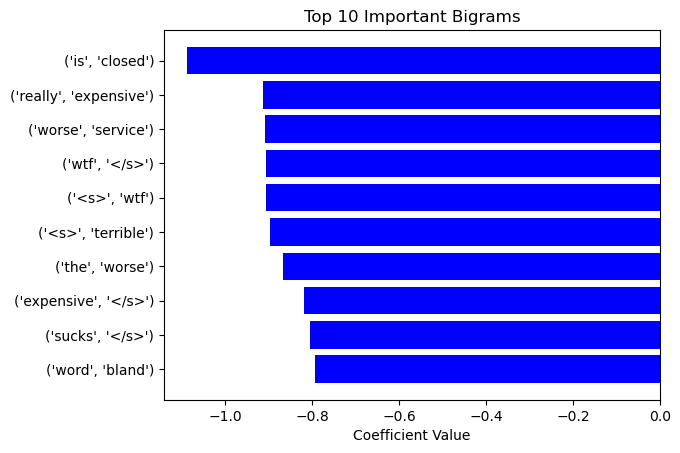

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients and bigram labels
feature_coefficients = ngram_model.regressor.coef_
bigrams = list(ngram_model.ngram_to_idx.keys())

# Get the top 10 most impactful bigrams (positive and negative)
top_indices = np.argsort(np.abs(feature_coefficients))[-10:]
top_bigrams = [str(bigrams[i]) for i in top_indices]  # Convert bigrams to strings
top_coefficients = feature_coefficients[top_indices]

# Create a horizontal bar plot
plt.barh(top_bigrams, top_coefficients, color='blue')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Important Bigrams')
plt.show()


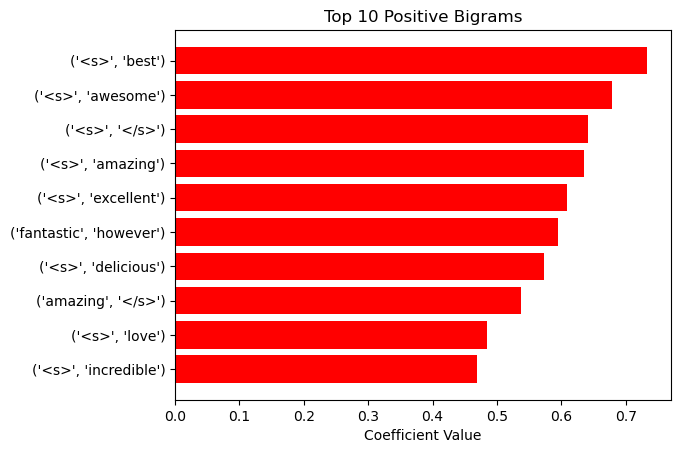

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients and bigram labels
feature_coefficients = ngram_model.regressor.coef_
bigrams = list(ngram_model.ngram_to_idx.keys())

# Get indices of top 10 positive coefficients
positive_indices = np.argsort(feature_coefficients)[-10:]  # Largest positive coefficients
top_positive_bigrams = [str(bigrams[i]) for i in positive_indices]  # Convert bigrams to strings
top_positive_coefficients = feature_coefficients[positive_indices]

# Create a horizontal bar plot
plt.barh(top_positive_bigrams, top_positive_coefficients, color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Positive Bigrams')
plt.show()


In [67]:
trigram_model = NGramRatingModel(n=3, alpha=0.7)
trigram_model.train(train_sequences, train_ratings)

# # Train Ridge Regressor
# features, targets = ngram_model._extract_features_and_targets(train_sequences, train_ratings)
# ngram_model.regressor.fit(features, targets)

# Validation and Test
val_mse = trigram_model.evaluate(val_sequences, val_ratings)

print(f"Validation MSE: {val_mse:.4f}")

[4. 4. 4. ... 4. 5. 3.]
Validation MSE: 0.9860


In [56]:
print(len(review_test))
print(len(train_sequences))

45982
16000


In [18]:
#baseline
train_average_stars = sum(d["stars"] for d in review_train) / len(review_train)
mse = sum((d["stars"] - train_average_stars) ** 2 for d in review_test) / len(review_test)
print(mse)

1.490833578439748
